In [1]:
### REQUIRED PACKAGES ###

%pip install requests pandas numpy matplotlib seaborn cvxpy openpyxl scikit-learn pycountry

# Make sure that the scipy version is 1.4.1 for the SyntheticControlMethods package
# Scipy 1.4.1 only works with Python 3.8 or older
# %pip uninstall scipy -y
# %pip install SyntheticControlMethods scipy==1.4.1

  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached openpyxl-3.1.2-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached pycountry-23.12.11-py3-none-any.whl.metadata (12 kB)
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached certifi-2024.2.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 514.0 kB/s eta 0:00:00a 0:00:01
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached osqp-0.6.5.tar.gz (228 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproje

In [46]:
import sys
import math
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry

### GLOBAL CONSTANTS ###

FREQUENCY = 'A' # 'M' for monthly, 'Q' for quarterly, 'A' for annual

# IMF Data API
IMF_BASE_URL = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
# International Financial Statistics database
IFS = 'IFS'
# Monetary and Financial Statistics database
MFS = 'MFS'

# IFS indicators
GDP = 'NGDP_XDC' if FREQUENCY == 'A' else 'NGDP_NSA_XDC'
CPI = 'PCPI_IX'
POLICY_RATE = 'FPOLM_PA'
SAVINGS_RATE = 'FISR_PA'
LENDING_RATE = 'FILR_PA'
DEPOSITS_RATE = 'FIDR_PA'
TREASURY_BILL_RATE = 'FITB_PA'
EXCHANGE_RATE = 'ENDE_XDC_USD_RATE'

# MFS indicators
M0 = 'FM0_XDC'
M0_SA = 'FM0_SA_XDC'
M1 = 'FM1_XDC'
M1_SA = 'FM1_SA_XDC'
M1_VAR = 'FM1V_XDC'
M2 = 'FM2_XDC'
M2_SA = 'FM2_SA_XDC'
M2_VAR = 'FM2V_XDC'
M3 = 'FM3_XDC'
M3_SA = 'FM3_SA_XDC'
M3_VAR = 'FM3V_XDC'
BASE_MONEY = 'FMA_XDC'
BASE_MONEY_SA = 'FMA_SA_XDC'
BASE_MONEY_VAR = 'FMAV__XDC'
BROAD_MONEY = 'FMB_XDC'
BROAD_MONEY_SA = 'FMB_SA_XDC'
BROAD_MONEY_VAR = 'FMBV_XDC'
BROAD_TO_BASE = 'FDSBR_PT'

# Other Indicators
M2_GROWTH_RATE = 'FM2_CH'
M2_TO_GDP_RATIO = 'FM2_NGDP'
M2_TO_RESERVES_RATIO = 'FM2_RES'
INTEREST_RATE_SPREAD = 'IR_SPREAD' # Lending Rate - Deposits Rate
CREDIT_PREMIUM_RATE = 'CREDIT_PREM_RATE' # Lending Rate - Treasury Bill Rate

M2_LOG = M2 + '_LOG'
BASE_MONEY_LOG = BASE_MONEY + '_LOG'
BROAD_MONEY_LOG = BROAD_MONEY + '_LOG'

REAL_GDP = GDP + '_R'
REAL_SAVINGS_RATE = SAVINGS_RATE + '_R'
REAL_LENDING_RATE = LENDING_RATE + '_R'
REAL_DEPOSITS_RATE = DEPOSITS_RATE + '_R'
REAL_TREASURY_BILL_RATE = TREASURY_BILL_RATE + '_R'

INFLATION_RATE = CPI + '_CH'
GDP_GROWTH_RATE = GDP + '_CH'
REAL_GDP_GROWTH_RATE = REAL_GDP + '_CH'
EXCHANGE_RATE_CHANGE = EXCHANGE_RATE + '_CH'

DEMEAN_POLICY_RATE = POLICY_RATE + '_DM'
DEMEAN_SAVINGS_RATE = SAVINGS_RATE + '_DM'
DEMEAN_LENDING_RATE = LENDING_RATE + '_DM'
DEMEAN_DEPOSITS_RATE = DEPOSITS_RATE + '_DM'
DEMEAN_TREASURY_BILL_RATE = TREASURY_BILL_RATE + '_DM'
DEMEAN_M2 = M2 + '_DM'
DEMEAN_M2_LOG = M2_LOG + '_DM'
DEMEAN_M2_GROWTH_RATE = M2_GROWTH_RATE + '_DM'
DEMEAN_M2_TO_GDP_RATIO = M2_TO_GDP_RATIO + '_DM'
DEMEAN_M2_TO_RESERVES_RATIO = M2_TO_RESERVES_RATIO + '_DM'
DEMEAN_BASE_MONEY = BASE_MONEY + '_DM'
DEMEAN_BASE_MONEY_LOG = BASE_MONEY_LOG + '_DM'
DEMEAN_BROAD_MONEY = BROAD_MONEY + '_DM'
DEMEAN_BROAD_MONEY_LOG = BROAD_MONEY_LOG + '_DM'
DEMEAN_BROAD_TO_BASE = BROAD_TO_BASE + '_DM'
DEMEAN_INFLATION_RATE = INFLATION_RATE + '_DM'
DEMEAN_GDP_GROWTH_RATE = GDP_GROWTH_RATE + '_DM'
DEMEAN_EXCHANGE_RATE_CHANGE = EXCHANGE_RATE_CHANGE + '_DM'
DEMEAN_INTEREST_RATE_SPREAD = INTEREST_RATE_SPREAD + '_DM'
DEMEAN_CREDIT_PREMIUM_RATE = CREDIT_PREMIUM_RATE + '_DM'

DEMEAN_REAL_SAVINGS_RATE = REAL_SAVINGS_RATE + '_DM'
DEMEAN_REAL_LENDING_RATE = REAL_LENDING_RATE + '_DM'
DEMEAN_REAL_DEPOSITS_RATE = REAL_DEPOSITS_RATE + '_DM'
DEMEAN_REAL_TREASURY_BILL_RATE = REAL_TREASURY_BILL_RATE + '_DM'
DEMEAN_REAL_GDP_GROWTH_RATE = REAL_GDP_GROWTH_RATE + '_DM'

INDICATORS_TO_DEMEAN = [
    DEPOSITS_RATE, GDP_GROWTH_RATE, INFLATION_RATE, TREASURY_BILL_RATE, LENDING_RATE,
    SAVINGS_RATE, POLICY_RATE, EXCHANGE_RATE_CHANGE, INTEREST_RATE_SPREAD, CREDIT_PREMIUM_RATE,
    M2, M2_LOG, M2_GROWTH_RATE, M2_TO_GDP_RATIO, M2_TO_RESERVES_RATIO, REAL_DEPOSITS_RATE,
    REAL_GDP_GROWTH_RATE, REAL_TREASURY_BILL_RATE, REAL_LENDING_RATE, REAL_SAVINGS_RATE,
    BASE_MONEY, BASE_MONEY_LOG, BROAD_MONEY, BROAD_MONEY_LOG, BROAD_TO_BASE
]

INDICATORS_TO_REAL = [
    DEPOSITS_RATE, GDP, TREASURY_BILL_RATE, LENDING_RATE, SAVINGS_RATE
]

INDICATORS_TO_GROWTH = [
    GDP, REAL_GDP, EXCHANGE_RATE
]

INDICATORS_TO_LOG = [
    M2, BROAD_MONEY, BASE_MONEY
]

INDICATORS_IN_IMF_API = {
    IFS: [
        GDP,
        CPI,
        POLICY_RATE,
        SAVINGS_RATE,
        LENDING_RATE,
        DEPOSITS_RATE,
        TREASURY_BILL_RATE,
        EXCHANGE_RATE
    ],
    MFS: [
        # M0,
        # M0_SA,
        # M1,
        # M1_SA,
        # M1_VAR,
        # M2,
        # M2_SA,
        # M2_VAR,
        # M3,
        # M3_SA,
        # M3_VAR,
        BASE_MONEY,
        # BASE_MONEY_SA,
        # BASE_MONEY_VAR,
        BROAD_MONEY,
        # BROAD_MONEY_SA,
        # BROAD_MONEY_VAR,
        BROAD_TO_BASE
    ]
}

INDICATORS_IN_FILES = {
    M2: 'data/broad-money-dataset.csv',
    M2_GROWTH_RATE: 'data/broad-money-growth-dataset.csv',
    M2_TO_GDP_RATIO: 'data/broad-money-to-gdp-dataset.csv.csv',
    M2_TO_RESERVES_RATIO: 'data/broad-money-to-reserves-dataset.csv'
}

### FUNCTIONS ###

def get_country_name(iso2_code):
    country = pycountry.countries.get(alpha_2=iso2_code)
    return country.name if country else None

def get_country_iso2_code(iso3_code):
    country = pycountry.countries.get(alpha_3=iso3_code)
    return country.alpha_2 if country else None

def get_country_iso3_code(iso2_code):
    country = pycountry.countries.get(alpha_2=iso2_code)
    return country.alpha_3 if country else None

def calculate_growth_rate(values):
    '''Calculate the year-over-year growth rate, handling NaN values.
    The first year will have a NaN growth rate since there is no previous year to compare to.

    :param values: List of values
    :return: List of growth rates, with NaN for missing or invalid values
    '''
    growth_rates = [np.nan]  # Initialize with NaN since the first year does not have a previous year to compare to.
    for i in range(1, len(values)):
        # Calculate growth rate only if both current and previous values are not NaN.
        if not np.isnan(values[i]) and not np.isnan(values[i-1]) and values[i-1] != 0:
            growth_rate = ((values[i] - values[i-1]) / values[i-1]) * 100
        else:
            growth_rate = np.nan
        growth_rates.append(growth_rate)
    return growth_rates

def convert_dates_to_number(dates):
    '''
    Convert a date string in the format 'YYYY', 'YYYY-QX', or 'YYYY-XX' to a number.
    E.g., '2010-Q1' will be converted to 2010.0, '2010-Q2' to 2010.25, etc.

    :param dates: Pandas Series containing date strings in the format 'YYYY', 'YYYY-QX', or 'YYYY-XX'
    :param FREQUENCY: A character indicating the FREQUENCY ('A' for annual, 'Q' for quarterly, 'M' for monthly)
    :return: Pandas Series of numbers representing the dates
    '''
    if FREQUENCY == 'A':
        # Directly convert year strings to integers
        return dates.astype(int)
    elif FREQUENCY == 'Q':
        # Split the year and quarter, then calculate the decimal year
        year_quarter = dates.str.split('-Q', expand=True)
        return year_quarter[0].astype(int) + (year_quarter[1].astype(int) - 1) / 4.0
    elif FREQUENCY == 'M':
        # Split the year and month, then calculate the decimal year
        year_month = dates.str.split('-', expand=True)
        return year_month[0].astype(int) + round((year_month[1].astype(int) - 1) / 12.0, 2)

def calculate_moving_average(values, window=4):
    '''
    Calculate the moving average for a given list of values.

    :param values: List of tuples (time, value)
    :param window: The number of periods over which to calculate the moving average
    :return: List of tuples (time, moving_average)
    '''
    ma_values = []
    # Convert list of tuples to a dictionary for easier manipulation
    value_dict = dict(values)
    times = [time for time, _ in values]

    for i in range(window - 1, len(times)):
        # Calculate average of the window
        window_values = [value_dict[times[j]] for j in range(i-window+1, i+1) if times[j] in value_dict]
        if len(window_values) == window:
            average = sum(window_values) / window
        else:
            average = np.nan  # Assign NaN if the window is not full (e.g., beginning periods)
        ma_values.append((times[i], average))

    return ma_values

def convert_nominal_to_real(indicator, nominal_values, inflation_rates, base_index=100):
    '''
    Converts nominal values to real values using the moving average of the Consumer Price Index (CPI).

    :param indicator: The indicator for which to convert nominal values to real values (e.g., NGDP_XDC, FITB_PA)
                      Different indicators have different formulas for calculating real values.
    :param nominal_values: List of tuples (time, nominal_value)
    :param inflation_rates: List of tuples (time, inflation_rate)
    :param base_index: The index value of the base year (usually 100)
    :return: List of tuples (time, real_value)
    '''
    # First, calculate the moving average for the CPI
    ma_inflation_rates = calculate_moving_average(inflation_rates, window=4)
    inflation_rates_dict = dict(ma_inflation_rates)  # Convert list of tuples to a dictionary

    real_values = []
    for time, nominal_value in nominal_values:
        if time in inflation_rates_dict and inflation_rates_dict[time] != 0:
            inflation_rate = inflation_rates_dict[time]
            if indicator == GDP:
                real_value = (nominal_value / (1 + inflation_rate/100)) * base_index
            elif indicator in [TREASURY_BILL_RATE, LENDING_RATE, SAVINGS_RATE, DEPOSITS_RATE]:
                real_value = nominal_value - inflation_rate
            else:
                print(f'ERROR: Indicator {indicator} not supported for real value calculation.')
                real_value = np.nan
        else:
            real_value = np.nan  # Assign NaN if no corresponding CPI value or CPI is zero
        real_values.append((time, real_value))

    return real_values

def calculate_rolling_volatility(values, window=8):
    '''
    Calculate rolling volatility using a window of the specified number of periods.

    :param values: List of tuples (time, value)
    :param window: The number of periods over which to calculate the rolling standard deviation
    :return: List of tuples (time, rolling_volatility)
    '''
    # Convert values to DataFrame for easier manipulation
    df = pd.DataFrame(values, columns=['time', 'value'])
    df.set_index('time', inplace=True)

    # Calculate rolling standard deviation
    rolling_std = df['value'].rolling(window=window, min_periods=1).std()

    # Return the result as a list of tuples
    return list(rolling_std.reset_index().itertuples(index=False, name=None))

In [65]:
### CONFIGURATION ###

start_period = '2010'
event_period = '2020'
end_period = '2023'
if FREQUENCY == 'Q':
    start_period += '-Q1'
    event_period += '-Q3'
    end_period += '-Q1'
elif FREQUENCY == 'M':
    start_period += '-01'
    event_period += '-10'
    end_period += '-01'

inputs = [
    POLICY_RATE,
    SAVINGS_RATE,
    LENDING_RATE,
    TREASURY_BILL_RATE,
    M2,
    M2_LOG,
    M2_GROWTH_RATE,
    M2_TO_GDP_RATIO,
    M2_TO_RESERVES_RATIO,
    BASE_MONEY,
    BASE_MONEY_LOG,
    BROAD_MONEY,
    BROAD_MONEY_LOG,
    BROAD_TO_BASE,
    INFLATION_RATE,
    GDP_GROWTH_RATE,
    EXCHANGE_RATE_CHANGE,
    INTEREST_RATE_SPREAD,
    CREDIT_PREMIUM_RATE
]
demeaned_inputs = [
    DEMEAN_POLICY_RATE,
    DEMEAN_SAVINGS_RATE,
    DEMEAN_LENDING_RATE,
    DEMEAN_TREASURY_BILL_RATE,
    DEMEAN_M2,
    DEMEAN_M2_LOG,
    DEMEAN_M2_GROWTH_RATE,
    DEMEAN_M2_TO_GDP_RATIO,
    DEMEAN_M2_TO_RESERVES_RATIO,
    DEMEAN_BASE_MONEY,
    DEMEAN_BASE_MONEY_LOG,
    DEMEAN_BROAD_MONEY,
    DEMEAN_BROAD_MONEY_LOG,
    DEMEAN_BROAD_TO_BASE,
    DEMEAN_INFLATION_RATE,
    DEMEAN_GDP_GROWTH_RATE,
    DEMEAN_EXCHANGE_RATE_CHANGE,
    DEMEAN_INTEREST_RATE_SPREAD,
    DEMEAN_CREDIT_PREMIUM_RATE
]
output = DEPOSITS_RATE
demeaned_output = DEMEAN_DEPOSITS_RATE

# The Bahamas
treatment_unit = 'BS'
control_units = [
    # Fixed Monetary Policy
    'AG', 'BB', 'BZ', 'DM', 'GD',
    'KN', 'VC', 'LC', 'MS', 'AI',
    # Flexible Monetary Policy
    'TT', 'JM', 'DO', 'MU', 'FJ'
]

# Nigeria
# treatment_unit = 'NG'
# control_units = [
#     # All data
#     'KE', 'GH', 'BD', 'ID', 'MZ',
#     'EG', 'ZA', 'MU', 'SL', 'CV'
#     # # Partial data
#     # 'RW', 'DZ', 'MA', 'AO', 'BW',
#     # 'MG', 'NA', 'SC', 'KM', 'SR',
#     # 'GE', 'CO', 'AZ', 'BY', 'BR',
#     # 'CL'
# ]

countries = [treatment_unit] + control_units

country_code = {country: index for index, country in enumerate(countries, start=1)}

### GET DATA FROM IMF DATA API ###

data = {}
for country in countries:
    data[country] = {}

for database, indicators in INDICATORS_IN_IMF_API.items():
    imf_indicators_key = '+'.join(indicators)
    imf_countries_key = '+'.join(countries)
    imf_request_key = f'CompactData/{database}/{FREQUENCY}.{imf_countries_key}.{imf_indicators_key}?startPeriod={start_period}&endPeriod={end_period}'
    imf_request_url = f'{IMF_BASE_URL}{imf_request_key}'

    try:
        response = requests.get(imf_request_url)
    except Exception as e:
        print('Failed to retrieve data using the IMF Data API; Error:', e)
        sys.exit()
    if response.status_code != 200:
        print(f'Failed to retrieve data using the IMF Data API; Response code: {response.status_code}')
        sys.exit()

    print(f'Successfully retrieved {database} data using the IMF Data API')

    try:
        series = response.json()['CompactData']['DataSet']['Series']

        for s in series:
            country = s['@REF_AREA']
            indicator = s['@INDICATOR']

            if 'Obs' not in s:
                print(f'No data found for {country}.{indicator}')
                continue

            print(f'{country}.{indicator} has {len(s["Obs"])} observations')

            observations = s['Obs']
            times = [obs.get('@TIME_PERIOD') for obs in observations]
            values = [float(obs.get('@OBS_VALUE')) if obs.get('@OBS_VALUE') else np.nan for obs in observations]

            data[country][indicator] = list(zip(times, values))

    except Exception as e:
        print('Failed to process data; Error:', e)
        sys.exit()

print('Retrieving additional data from files')

# Get indicators not available through the API from CSV files
for indicator, file_path in INDICATORS_IN_FILES.items():
    # Load the CSV file, skip initial rows
    file_data = pd.read_csv(file_path, skiprows=2)

    # Filter the data for the relevant countries
    countries_iso3 = [get_country_iso3_code(code) for code in countries]
    file_data = file_data[file_data['Country Code'].isin(countries_iso3)]

    # Filter the data for the relevant years
    years = [str(year) for year in range(int(start_period), int(end_period) + 1)]
    filtered_data = file_data[['Country Code'] + years]

    for index, row in filtered_data.iterrows():
        country_iso3 = row['Country Code']
        country_iso2 = get_country_iso2_code(country_iso3)
        country_data = []
        for year in years:
            country_data.append((year, row[year]))

        data[country_iso2][indicator] = country_data

        print(f'{country_iso2}.{indicator} has {len(data[country_iso2][indicator])} observations')

# Add missing data manually
if 'BB' in data:
    if FREQUENCY == 'A':
        # Add latest value, 2023, manually
        data['BB']['FIDR_PA'].append(('2023', 0.15))
    elif FREQUENCY == 'Q':
        data['BB']['FIDR_PA'].append(('2023-Q1', 0.15))
        data['BB']['FIDR_PA'].append(('2023-Q2', 0.15))
        data['BB']['FIDR_PA'].append(('2023-Q3', 0.15))

if 'TT' in data:
    if FREQUENCY == 'Q':
        data['TT']['FIDR_PA'].append(('2022-Q1', 1.5))
        data['TT']['FIDR_PA'].append(('2022-Q2', 1.5))
        data['TT']['FIDR_PA'].append(('2022-Q3', 1.5))


### REFINE DATA ###

for country in countries:
    # Calculate the inflation rate
    if CPI in data[country]:
        times = [obs[0] for obs in data[country][CPI]]
        values = calculate_growth_rate([obs[1] for obs in data[country][CPI]])
        data[country][INFLATION_RATE] = list(zip(times, values))
    # Calculate the interest rate spread -> Lending Rate - Deposits Rate
    if LENDING_RATE in data[country] and DEPOSITS_RATE in data[country]:
        lending_rates = dict(data[country][LENDING_RATE])
        deposits_rates = dict(data[country][DEPOSITS_RATE])
        interest_rate_spread = [(time, lending_rates[time] - deposits_rates.get(time, np.nan)) for time in lending_rates]
        data[country][INTEREST_RATE_SPREAD] = interest_rate_spread
    # Calculate the bank premium rate -> Lending Rate - Treasury Bill Rate
    if TREASURY_BILL_RATE in data[country] and LENDING_RATE in data[country]:
        treasury_bill_rates = dict(data[country][TREASURY_BILL_RATE])
        lending_rates = dict(data[country][LENDING_RATE])
        credit_premium_rate = [(time, lending_rates[time] - treasury_bill_rates.get(time, np.nan)) for time in lending_rates]
        data[country][CREDIT_PREMIUM_RATE] = credit_premium_rate

# Calculate the real values for GDP, Treasury Bills, Savings Rate, Lending Rate, Deposits Rate
# This is an approximation using the moving average of the inflation rate
for indicator in INDICATORS_TO_REAL:
    for country in countries:
        print(f'Calculating real values for {country}.{indicator}')
        if indicator in data[country] and INFLATION_RATE in data[country]:
            real_indicator = indicator + '_R'
            data[country][real_indicator] = convert_nominal_to_real(indicator, data[country][indicator], data[country][INFLATION_RATE])
            print(f'{country}.{real_indicator} has {len(data[country][real_indicator])} observations')

# Calculate the change rates for GDP, Real GDP, and Exchange Rate
for indicator in INDICATORS_TO_GROWTH:
    for country in countries:
        print(f'Calculating growth rate for {country}.{indicator}')
        if indicator in data[country]:
            times = [obs[0] for obs in data[country][indicator]]
            values = calculate_growth_rate([obs[1] for obs in data[country][indicator]])
            data[country][indicator + '_CH'] = list(zip(times, values))
            print(f'{country}.{indicator}_CH has {len(data[country][indicator])} observations')

# Calculate the logarithm of the money supplies
for indicator in INDICATORS_TO_LOG:
    for country in countries:
        print(f'Calculating logarithm for {country}.{indicator}')
        if indicator in data[country]:
            data[country][indicator + '_LOG'] = [(time, math.log(value)) for time, value in data[country][indicator]]
            print(f'{country}.{indicator}_LOG has {len(data[country][indicator])} observations')

# # Calculate rolling volatility for the Interest Rate on Deposits
# for country in countries:
#     if REAL_DEPOSITS_RATE in data[country]:
#         # Extract the real deposit rates and times
#         values = data[country][REAL_DEPOSITS_RATE]
#         # Calculate and store the rolling volatility
#         values = calculate_rolling_volatility(values)
#         data[country][REAL_DEPOSITS_RATE + '_VOL'] = values
#     else:
#         real_deposit_rate_rolling_volatility[country] = []  # No data for this indicator

for country in countries:
    for indicator in INDICATORS_TO_DEMEAN:
        print(f'Calculating demean for {country}.{indicator}')

        # Demean the data (only based on the prediction and optimization period)
        if indicator in data[country]:
            # Filter values within the specified time window, between the start date and the event date, and calculate the mean
            window_values = [value for year, value in data[country][indicator] if start_period <= year <= event_period]

            mean_value = np.nanmean(window_values) if len(window_values) > 0 else 0

            # Demean all values using the calculated mean from the window
            demeaned_values = [(year, value - mean_value) for year, value in data[country][indicator]]

            # Update the data structure with demeaned values
            data[country][indicator + '_DM'] = demeaned_values
            print(f'{country}.{indicator}_DM has {len(demeaned_values)} observations')

        # # Demean the data (based on the entire period)
        # if indicator in data[country]:
        #     values = [obs[1] for obs in data[country][indicator]]
        #     mean_value = np.nanmean(values)
        #     demeaned_values = [(obs[0], obs[1] - mean_value) for obs in data[country][indicator]]
        #     data[country][indicator + '_DM'] = demeaned_values
        #     print(f'{country}.{indicator} has {len(data[country][indicator])} observations')

Successfully retrieved IFS data using the IMF Data API
KN.ENDE_XDC_USD_RATE has 14 observations
AI.ENDE_XDC_USD_RATE has 14 observations
BZ.ENDE_XDC_USD_RATE has 14 observations
MS.ENDE_XDC_USD_RATE has 14 observations
KN.PCPI_IX has 14 observations
GD.ENDE_XDC_USD_RATE has 14 observations
DM.ENDE_XDC_USD_RATE has 14 observations
AI.PCPI_IX has 14 observations
AG.PCPI_IX has 14 observations
BS.PCPI_IX has 14 observations
FJ.ENDE_XDC_USD_RATE has 14 observations
AG.ENDE_XDC_USD_RATE has 14 observations
JM.PCPI_IX has 14 observations
MS.PCPI_IX has 14 observations
GD.PCPI_IX has 14 observations
MU.PCPI_IX has 14 observations
TT.PCPI_IX has 14 observations
VC.PCPI_IX has 14 observations
LC.PCPI_IX has 14 observations
BB.PCPI_IX has 12 observations
JM.ENDE_XDC_USD_RATE has 14 observations
DM.PCPI_IX has 14 observations
DO.PCPI_IX has 14 observations
VC.ENDE_XDC_USD_RATE has 14 observations
BZ.PCPI_IX has 14 observations
BS.ENDE_XDC_USD_RATE has 14 observations
FJ.PCPI_IX has 13 observation

/var/folders/9x/p8jlzgy11cv4_f8srk_0w80w0000gn/T/ipykernel_31453/3280534696.py:245: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(window_values) if len(window_values) > 0 else 0


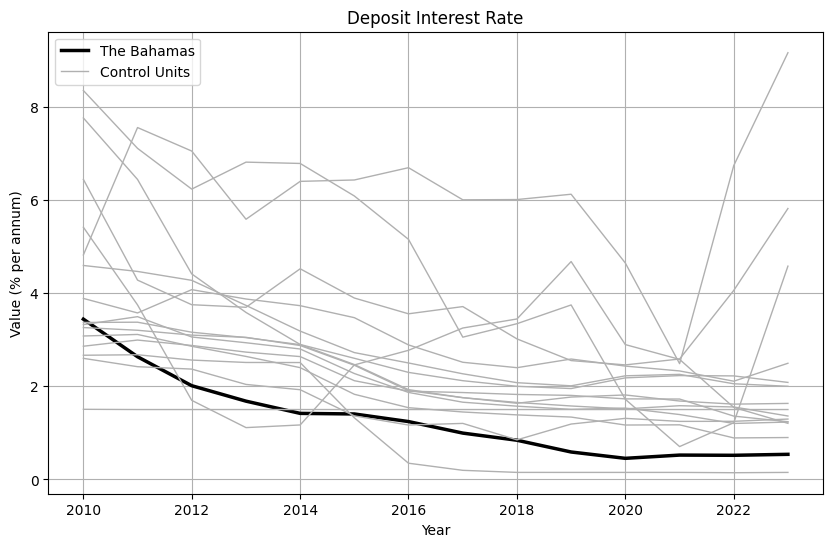

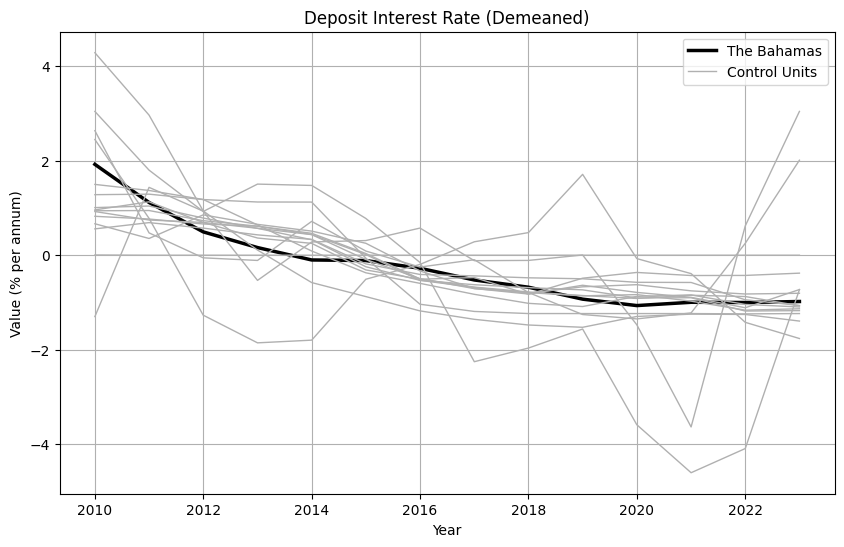

In [74]:
### PLOT DATA ###
import seaborn as sns

treatment_color = 'black' # Black color for the treatment unit
control_color = '#b0b0b0' # Greyish color for control units

# Convert to DataFrame for easier manipulation
df = pd.DataFrame([
    {'Country': country, 'Year': pd.to_datetime(year), 'Value': float(value), 'Indicator': indicator}
    for country, indicators in data.items()
    for indicator, yearly_data in indicators.items()
    for year, value in yearly_data
])

for indicator in [output, demeaned_output]:
    plotted_data = False
    plt.figure(figsize=(10, 6))  # Larger figure for better visibility

    for country in countries:
        country_name = get_country_name(country)

        # Check if the indicator exists for the country
        if indicator in data[country]:
            plotted_data = True

            # Prepare the data, transforming the date format
            times = [pd.to_datetime(obs[0]) for obs in data[country][indicator]]
            values = [float(obs[1]) if obs[1] else np.nan for obs in data[country][indicator]]

            # Plot the data for the country
            # plt.plot(times, values, linewidth=2, markersize=8, label=country_name)
            if country == treatment_unit:
                plt.plot(times, values, color=treatment_color, linewidth=2.5)
            else:
                plt.plot(times, values, color=control_color, linewidth=1)

    if plotted_data:
        # Manual entries for the legend
        plt.plot([], [], color=treatment_color, linewidth=2.5, label='The Bahamas')
        plt.plot([], [], color=control_color, linewidth=1, label='Control Units')

        if indicator == output:
            plt.title('Deposit Interest Rate')
        elif indicator == demeaned_output:
            plt.title('Deposit Interest Rate (Demeaned)')
        else:
            plt.title(f'{indicator} Over Time')

        plt.xlabel('Year')
        plt.ylabel('Value (% per annum)')
        plt.grid(True)
        plt.legend()
    else:
        plt.close()  # Close the plot if no data is present to avoid empty figures

    # Uncomment the next line if you want to save the figure to a file
    # plt.savefig(f"{indicator}_plot.png")

    plt.show()

# # Using seaborn for plotting
# for indicator in [demeaned_output] + demeaned_inputs:
#     plt.figure(figsize=(10, 6))

#     sns.lineplot(
#         data=df[df['Indicator'] == indicator],
#         x='Year',
#         y='Value',
#         hue='Country',
#         style='Country',
#         markers=True,
#         dashes=False,
#         palette='bright',
#         linewidth=2.5)

#     plt.title(f'{indicator} Over Time')
#     plt.xlabel('Year')
#     plt.ylabel(indicator)
#     plt.grid(True)
#     plt.show()

# # Plot indicators into separate figures
# for indicator in [demeaned_output] + demeaned_inputs:
#     plotted_data = False
#     plt.figure(figsize=(10, 6))  # Larger figure for better visibility

#     for country in countries:
#         country_name = get_country_name(country)

#         # Check if the indicator exists for the country
#         if indicator in data[country]:
#             plotted_data = True

#             # Prepare the data, transforming the date format
#             times = [pd.to_datetime(obs[0]) for obs in data[country][indicator]]
#             values = [float(obs[1]) if obs[1] else np.nan for obs in data[country][indicator]]

#             # Plot the data for the country
#             # plt.plot(times, values, linewidth=2, markersize=8, label=country_name)
#             if country == treatment_unit:
#                 plt.plot(times, values, color=treatment_color, linewidth=2.5)
#             else:
#                 plt.plot(times, values, color=control_color, linewidth=1)

#     if plotted_data:
#         # Manual entries for the legend
#         plt.plot([], [], color=treatment_color, linewidth=2.5, label='The Bahamas')
#         plt.plot([], [], color=control_color, linewidth=1, label='Control Units')

#         # plt.title(f'{indicator} Over Time')
#         plt.title('Deposit Interest Rate')
#         plt.xlabel('Year')
#         plt.ylabel('Value (% per annum)')
#         plt.grid(True)
#         plt.legend()
#     else:
#         plt.close()  # Close the plot if no data is present to avoid empty figures

#     # Uncomment the next line if you want to save the figure to a file
#     # plt.savefig(f"{indicator}_plot.png")

#     plt.show()

# # Plot indicators into a tiled grid
# # Determine the layout of the subplot grid
# num_indicators = len([demeaned_output] + demeaned_inputs)
# num_columns = 2  # Or any other number you wish
# num_rows = (num_indicators + num_columns - 1) // num_columns  # This ensures enough rows

# plt.figure(figsize=(5 * num_columns, 4 * num_rows))

# i = 1
# # Create a subplot for each indicator
# for indicator in [demeaned_output] + demeaned_inputs:
#     ax = plt.subplot(num_rows, num_columns, i)
#     i += 1

#     # Track if we have added any data to plot (for cases where an indicator may not be present)
#     plotted_data = False

#     for country in countries:
#         # Check if the indicator exists for the country
#         if indicator in data[country]:
#             plotted_data = True

#             # Prepare the data, transforming the date format
#             times = [pd.to_datetime(obs[0]) for obs in data[country][indicator]]
#             values = [float(obs[1]) if obs[1] else np.nan for obs in data[country][indicator]]

#             # Plot the data for the country
#             ax.plot(times, values, marker='o', label=get_country_name(country))

#     # Customize the subplot
#     if plotted_data:
#         ax.set_title(indicator)
#         ax.set_xlabel('Year')
#         ax.set_ylabel('Value')
#         ax.grid(True)
#         # ax.legend()
#     else:
#         plt.delaxes(ax)  # Remove the subplot if no data is present for the indicator

# # Adjust the layout to prevent overlapping
# plt.tight_layout()
# plt.show()

In [56]:
### FORMAT DATA AND EXPORT TO CSV

rows_list = []

# Iterate over each country and its corresponding data
for country, indicators in data.items():
    # Prepare a nested dictionary for each indicator by year
    year_data = {}
    for indicator, observations in indicators.items():
        for obs in observations:
            year, value = obs
            value = float(value) if value else np.nan  # Ensure value is float or NaN
            if year not in year_data:
                year_data[year] = {}
            year_data[year][indicator] = value

    # Now, flatten the year_data dictionary into rows for our DataFrame
    for year, indicators in year_data.items():
        row = {
            'code': country_code[country],
            'country': country,
            'year': year,
        }
        # Add each indicator's value to the row; if an indicator is missing, the value will be NaN
        row.update(indicators)
        rows_list.append(row)

# Convert the list of rows into a DataFrame
dataframe = pd.DataFrame(rows_list)

# Ensure all indicators are present as columns, filling missing ones with NaN
final_columns = ['code', 'country', 'year'] + [output] + inputs + [demeaned_output] + demeaned_inputs
for col in final_columns:
    if col not in dataframe.columns:
        dataframe[col] = np.nan

# Reorder the DataFrame columns as needed
dataframe = dataframe[final_columns]

# Transform date to int or float format according to frequency
dataframe['year'] = convert_dates_to_number(dataframe['year'])

# Optionally, sort the DataFrame by country and year for better readability
dataframe.sort_values(by=['code', 'year'], inplace=True)

# Save the DataFrame to a CSV file
dataframe.to_csv('data/synthetic-control-dataset.csv', index=False)

print("CSV file created successfully.")

CSV file created successfully.


In [57]:
### SYNTHETIC CONTROL

#Import packages
import pandas as pd
from SyntheticControlMethods import Synth, DiffSynth

#Import data
file_path = 'data/synthetic-control-dataset.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=(["code", output] + inputs), axis=1)

#Fit classic Synthetic Control
sc = Synth(data, demeaned_output, "country", "year", 2020, "BS", pen=0)
# dsc = DiffSynth(data, "FIDR_PA", "country", "year", 2020, "BS", not_diff_cols=["NGDP_XDC","PCPI_IX","FITB_PA","FISR_PA","FILR_PA"], pen="auto")

print("\nSynthetic Control Wieghts")
print(sc.original_data.weight_df)

#Visualize synthetic control
sc.plot(["original", "pointwise", "cumulative"], treated_label="The Bahamas", synth_label="Synthetic The Bahamas", treatment_label="Introduction of CBDC")

ModuleNotFoundError: No module named 'SyntheticControlMethods'

In [129]:
from pprint import pprint
pprint(vars(sc.original_data))

{'comparison_df':                      BS  Synthetic BS  WMAPE  Importance
FIDR_PA            3.50          3.55   0.34        0.08
NGDP_XDC           2.17          2.31   1.48        0.06
PCPI_IX            2.10          3.02   0.92        0.14
ENDE_XDC_USD_RATE  1.00          2.96   1.96        0.08
FITB_PA            2.32          4.66   2.34        0.32
FISR_PA            2.49          3.67   1.33        0.33
FILR_PA            5.89          9.73   3.84        0.00,
 'control_covariates': array([[ 1.29332322,  1.35375416,  1.73029555,  1.16938587,  1.93547525,
         1.17500813,  1.10190492,  1.08676972,  1.29357714],
       [ 1.39128517,  0.38678688,  1.27072308,  0.19010607,  2.5760249 ,
         1.40160285,  1.1223811 , -0.62796434,  1.2724527 ],
       [ 0.60017766,  1.37929897,  0.43072973,  0.55576517,  1.48141924,
         0.77649248,  0.67841502,  1.32937225,  0.84375744],
       [ 0.92979187,  0.80714146,  0.53681924,  0.94010812,  0.83202001,
         1.03395868,  3.638

BS - FIDR_PA - A
{'@FREQ': 'A', '@REF_AREA': 'BS', '@INDICATOR': 'FIDR_PA', '@UNIT_MULT': '0', '@TIME_FORMAT': 'P1Y', 'Obs': [{'@TIME_PERIOD': '1985', '@OBS_VALUE': '6.39833333333333'}, {'@TIME_PERIOD': '1986', '@OBS_VALUE': '5.57'}, {'@TIME_PERIOD': '1987', '@OBS_VALUE': '5.5'}, {'@TIME_PERIOD': '1988', '@OBS_VALUE': '5.97'}, {'@TIME_PERIOD': '1989', '@OBS_VALUE': '6.48333333333333'}, {'@TIME_PERIOD': '1990', '@OBS_VALUE': '6.57083333333333'}, {'@TIME_PERIOD': '1991', '@OBS_VALUE': '6.91666666666667'}, {'@TIME_PERIOD': '1992', '@OBS_VALUE': '6.13333333333333'}, {'@TIME_PERIOD': '1993', '@OBS_VALUE': '5.19'}, {'@TIME_PERIOD': '1994', '@OBS_VALUE': '4.30083333333333'}, {'@TIME_PERIOD': '1995', '@OBS_VALUE': '4.19666666666667'}, {'@TIME_PERIOD': '1996', '@OBS_VALUE': '5.13583333333333'}, {'@TIME_PERIOD': '1997', '@OBS_VALUE': '5.22833333333333'}, {'@TIME_PERIOD': '1998', '@OBS_VALUE': '5.3625'}, {'@TIME_PERIOD': '1999', '@OBS_VALUE': '4.5725'}, {'@TIME_PERIOD': '2000', '@OBS_VALUE': '4.0

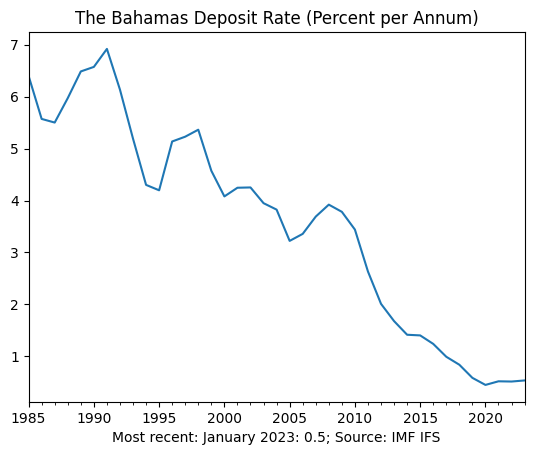

In [291]:

import requests # Python 3.6
import pandas as pd # pandas version 0.23

FREQUENCY = 'A' # 'M' for monthly, 'Q' for quarterly, 'A' for annual
COUNTRY = 'BS' # ISO country code
INDICATOR = 'FIDR_PA' # 'FIDR_PA' for Interest Rates, Deposit Interest

url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
key = f'CompactData/IFS/{FREQUENCY}.{COUNTRY}.{INDICATOR}'

# Navigate to series in API-returned JSON data
data = (requests.get(f'{url}{key}').json()
        ['CompactData']['DataSet']['Series'])

print(f"{COUNTRY} - {INDICATOR} - {FREQUENCY}")
print(data)

# Create pandas dataframe from the observations
data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')] for obs in data['Obs']]

df = pd.DataFrame(data_list, columns=['date', 'value'])
df = df.set_index(pd.to_datetime(df['date']))['value'].astype('float')

# Save cleaned dataframe as a csv file
df.to_csv(f'data/{FREQUENCY}-{COUNTRY}-{INDICATOR}.csv', header=True)

# Title and text with recent value
title = 'The Bahamas Deposit Rate (Percent per Annum)'
recentdt = df.index[-1].strftime('%B %Y')
recentval = round(df[-1], 1)
recent = f'Most recent: {recentdt}: {recentval}'
source = 'Source: IMF IFS'

# Basic plot
plot = df.plot(title=title)
plot = plot.set_xlabel(f'{recent}; {source}')

In [ ]:
# EXAMPLE CODE IMF DATA API

# import pandas as pd          # pandas version 0.23

# baseyr = data['@BASE_YEAR']  # Save the base year

# # Create pandas dataframe from the observations
# data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')]
#              for obs in data['Obs']]

# df = pd.DataFrame(data_list, columns=['date', 'value'])

# df = df.set_index(pd.to_datetime(df['date']))['value'].astype('float')

# # Save cleaned dataframe as a csv file
# df.to_csv('data/UK_import_price_index.csv', header=True)

# # Title and text with recent value
# title = f'U.K. Import Prices (index, {baseyr})'
# recentdt = df.index[-1].strftime('%B %Y')
# recentval = round(df[-1], 1)
# recent = f'Most recent: {recentdt}: {recentval}'
# source = 'Source: IMF IFS'

# # Basic plot
# plot = df.plot(title=title, colormap='Set1')
# plot = plot.set_xlabel(f'{recent}; {source}')